(ODE_Lotka_Volterra_fit_multiple_ways)= 
# ODE Lotka-Volterra With Bayesian Inference in Multiple Ways

:::{post} January 10, 2023
:tags: ODE, pytensor op, gradient-free inference, pytensor scan
:category: intermediate, how-to
:author: [Greg Brunkhorst]{https://github.com/gbrunkhorst}
:::

In [51]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt

from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint
from scipy.optimize import least_squares

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1+5.ga7f361bd


In [52]:
%load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Purpose
The purpose of this notebook is to demonstrate how to perform Bayesian inference on a system of ordinary differential equations (ODEs), both with and without gradients.  The accuracy and efficiency of different samplers are compared.    
### Outline
* Background
    * Motivation
    * Lotka-Volterra Predator Prey Model
    * Hudson's Bay Company Data
* Scipy `odeint`
    * Specification
    * Least Squares Solution
* Gradient-free Bayesian Inference
    * Wrapping `odeint` in a Pytensor operator for use in PyMC
    * Bayesian inference using gradient-free methods
        * Slice Sampler
        * DEMetropolisZ Sampler
        * DEMetropolis Sampler
        * Metropolis Sampler
        * Sequential Monte Carlo (SMC) Sampler
* Bayesian Inference with Gradients
    * `pymc.ode.DifferentialEquation` specification with the NUTs Sampler
    * Looping in PyMC with `Pytensor.scan` and the NUTs Sampler
### Key Conclusions
* Based on the experiments in this notebook, the most simple and efficient method for performing Bayesian inference on the Lotka-Volterra equations was to specify the ODE system in Scipy, wrap the function as an Pytensor op, and use a Differential Evolution Metropolis (DEMetropolis) sampler in PyMC.  

## Background
### Motivation
Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using PyMC. The Lotka-Volterra model used in this example has often been used for benchmarking Bayesian inference methods (e.g., in [Stan](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html)).  See also Richard McElraith's discussion of this model in [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/), Chapter 16 of the Second Edition.


### Lotka-Volterra Predator-Prey Model
The Lotka-Volterra model describes the interaction between a predator and prey species. This ODE given by:  
$$
\begin{aligned}
\frac{d x}{dt} &=\alpha x -\beta xy \\ 
\frac{d y}{dt} &=-\gamma y + \delta xy
\end{aligned}
$$

The state vector $X(t)=[x(t),y(t)]$ comprises the densities of the prey and the predator species respectively.  Parameters $\boldsymbol{\theta}=[\alpha,\beta,\gamma,\delta, x(0),y(0)]$ are the unknowns that we wish to infer from experimental observations.  $x(0), y(0)$ are the initial values of the states needed to solve the ODE, and $\alpha,\beta,\gamma$, and $\delta$ are unknown model parameters which represent the following:  
* $\alpha$ is the growing rate of prey when there's no predator.
* $\beta$ is the dying rate of prey due to predation.
* $\gamma$ is the dying rate of predator when there is no prey.
* $\delta$ is the growing rate of predator in the presence of prey.    

### The Hudson's Bay Company data
The Lotka-Volterra predator prey model has been used to successfully explain the dynamics of natural populations of predators and prey, such as the lynx and snowshoe hare data of the Hudson's Bay Company. Since the dataset is small, we will hand-enter the values.

In [53]:
# fmt: off
data = pd.DataFrame(dict(
    year = np.arange(1900., 1921., 1),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))
data.head()
# fmt: on

year  lynx  hare
0  1900.0   4.0  30.0
1  1901.0   6.1  47.2
2  1902.0   9.8  70.2
3  1903.0  35.2  77.4
4  1904.0  59.4  36.3

In [54]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Hudson's Bay Company Data"):
    ax.plot(data.year, data.lynx, color="b", lw=lw, marker="o", markersize=12, label="Lynx (Data)")
    ax.plot(data.year, data.hare, color="g", lw=lw, marker="+", markersize=14, label="Hare (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([1900, 1920])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pelts (Thousands)", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

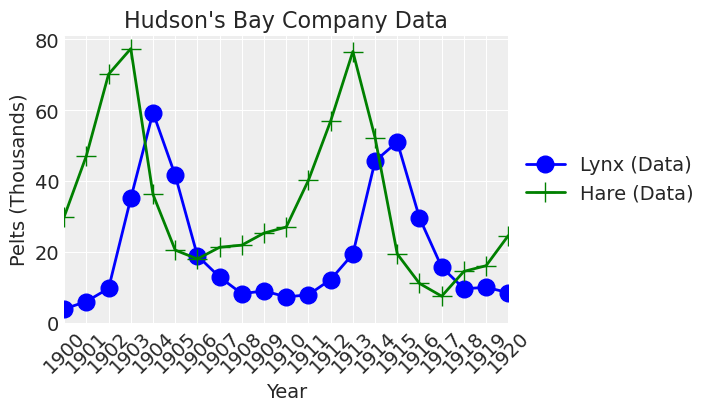

In [55]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_data(ax);

### Problem Statement
The purpose of this analysis is to estimate, with uncertainty, the parameters for the Lotka-Volterra model for the Hudson's Bay Company data from 1900 to 1920.  

## Scipy `odeint`

Here, we make a Python function that represents the right-hand-side of the ODE equations with the call signature needed for the `odeint` function.  Note that Scipy's `solve_ivp` could also be used, but the older `odeint` function was faster in speed tests and is therefore used in this notebook.  

In [56]:
# define the right hand side of the ODE equations in the Scipy odeint signature
def rhs(X, t, theta):
    # unpack parameters
    x, y = X
    alpha, beta, gamma, delta, xt0, yt0 = theta
    # equations
    dx_dt = alpha * x - beta * x * y
    dy_dt = -gamma * y + delta * x * y
    return [dx_dt, dy_dt]

To get a feel for the model and make sure the equations are working correctly, let's run the model once with reasonable values for $\theta$ and plot the results.  

In [57]:
# plot model function
def plot_model(
    ax,
    x_y,
    time=np.arange(1900, 1921, 0.01),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):

    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="g", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

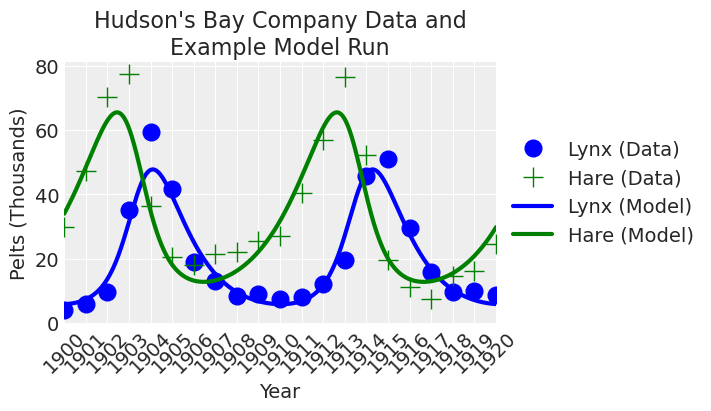

In [58]:
# note theta = alpha, beta, gamma, delta, xt0, yt0
theta = [0.52, 0.026, 0.84, 0.026, 34.0, 5.9]
time = np.arange(1900, 1921, 0.01)

# call Scipy's odeint function
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))

# plot
fig, ax = plt.subplots(figsize=(7, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y);

Looks like the `odeint` function is working as expected.  

## Least Squares Solution

Now, we can solve the ODE using least squares.  Make a function that calculates the residual error.  

In [59]:
# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    return (
        data[["hare", "lynx"]] - odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))
    ).values.flatten()

Feed the residual error function to the Scipy `least_squares` solver.   

In [60]:
# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid, x0=theta)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame()
parameter_names = ["alpha", "beta", "gamma", "delta", "h0", "l0"]
df["Parameter"] = parameter_names
df["Least Squares Solution"] = results.x
df.round(2)

Parameter  Least Squares Solution
0     alpha                    0.48
1      beta                    0.02
2     gamma                    0.93
3     delta                    0.03
4        h0                   34.91
5        l0                    3.86

Plot  

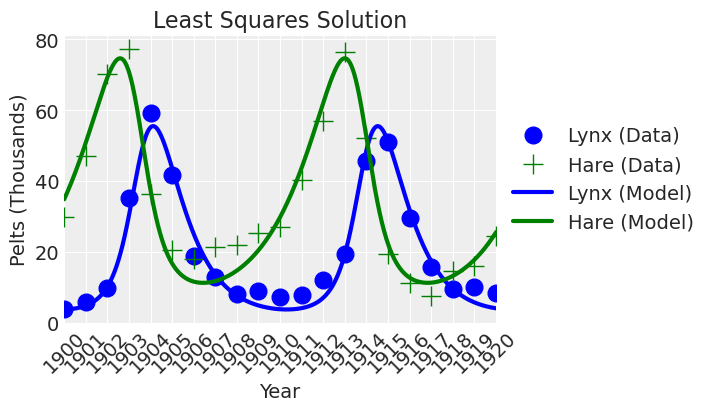

In [61]:
time = np.arange(1900, 1921, 0.01)
theta = results.x
x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
fig, ax = plt.subplots(figsize=(7, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y, title="Least Squares Solution");

Looks right.  If we didn't care about uncertainty, then we would be done.  But we do care about uncertainty, so let's move on to Bayesian inference.  

## PyMC Model Specification for Gradient-Free Bayesian Inference

Like other Numpy or Scipy-based functions, the `scipy.integrate.odeint` function cannot be used directly in a PyMC model because PyMC needs to know the variable input and output types to compile.  Therefore, we use a Pytensor wrapper to give the variable types to PyMC.  Then the function can be used in PyMC in conjunction with gradient-free samplers.   

### Convert Python Function to a Pytensor Operator using @as_op decorator
We tell PyMC the input variable types and the output variable types using the `@as_op` decorator.  `odeint` returns Numpy arrays, but we tell PyMC that they are Pytensor double float tensors for this purpose.  

In [62]:
# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))

### PyMC Model

Now, we can specify the PyMC model using the ode solver!  For priors, we will use the results from the least squares calculation (`results.x`) to assign priors that start in the right range.  These are empirically derived weakly informative priors.  We also make them positive-only for this problem.      

We will use a normal likelihood on untransformed data (i.e., not log transformed) to best fit the peaks of the data. 

In [63]:
theta = results.x  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=theta[0], lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=theta[1], lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=theta[2], lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=theta[3], lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=theta[4], lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=theta[5], lower=0, initval=theta[5])
    sigma = pm.TruncatedNormal("sigma", mu=10, sigma=10, lower=0)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([alpha, beta, gamma, delta, xt0, yt0])
    )

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

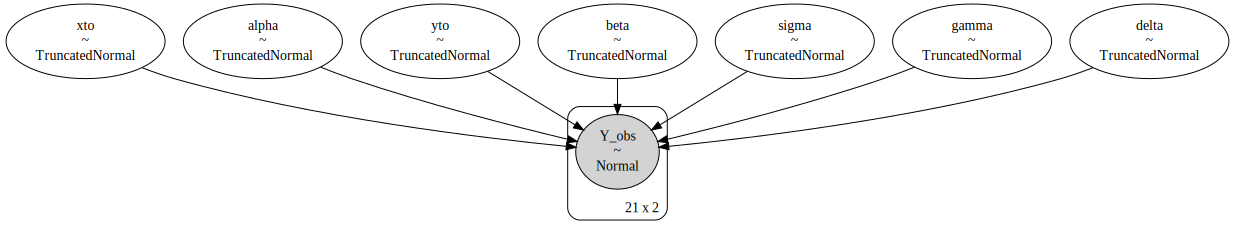

In [64]:
pm.model_to_graphviz(model=model)

### Plotting Functions
A couple of plotting functions that we will reuse below.  

In [65]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta", "xto", "yto"]
    row = trace_df.iloc[row_idx, :][cols]

    # alpha, beta, gamma, delta, Xt0, Yt0
    time = np.arange(1900, 1921, 0.01)
    theta = row
    x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [66]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)


## Gradient-Free Sampler Options
Having good gradient free samplers can open up the models that can be fit within PyMC.  There are five options for gradient-free samplers in PyMC that are applicable to this problem: 
* `Slice` - the default gradient-free sampler
* `DEMetropolisZ` - a differential evolution Metropolis sampler that uses the past to inform sampling jumps
* `DEMetropolis` - a differential evolution Metropolis sampler
* `Metropolis` - the vanilla Metropolis sampler
* `SMC` - Sequential Monte Carlo  

Let's give them a shot.

A few notes on running these inferences.  For each sampler, the number of tuning steps and draws have been reduced to run the inference in a reasonable amount of time (on the order of minutes).  This is not a sufficient number of draws to get a good inferences, in some cases, but it works for demonstration purposes.  In addition, multicore processing was not working for the Pytensor op function on all machines, so inference is performed on one core.         

### Slice Sampler

In [67]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

In [68]:
# Specify the sampler
sampler = "Slice Sampler"
tune = draws = 500

# Inference!
with model:
    trace_slice = pm.sample(step=[pm.Slice(vars_list)], tune=tune, draws=draws, cores=1)
trace = trace_slice
az.summary(trace)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [gamma]
>Slice: [delta]
>Slice: [xto]
>Slice: [yto]
>Slice: [sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 310 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.509  0.027   0.460    0.559      0.006    0.004      25.0      74.0   
beta    0.026  0.001   0.023    0.029      0.000    0.000      40.0     190.0   
gamma   0.877  0.051   0.785    0.968      0.011    0.008      24.0      46.0   
delta   0.026  0.002   0.024    0.029      0.000    0.000      29.0      62.0   
xto    34.160  1.604  31.226   37.155      0.195    0.138      68.0     186.0   
yto     4.239  0.582   3.216    5.323      0.092    0.065      40.0      74.0   
sigma   4.236  0.513   3.438    5.351      0.021    0.015     591.0     721.0   

       r_hat  
alpha   1.11  
beta    1.07  
gamma   1.11  
delta   1.08  
xto     1.02  
yto     1.09  
sigma   1.00

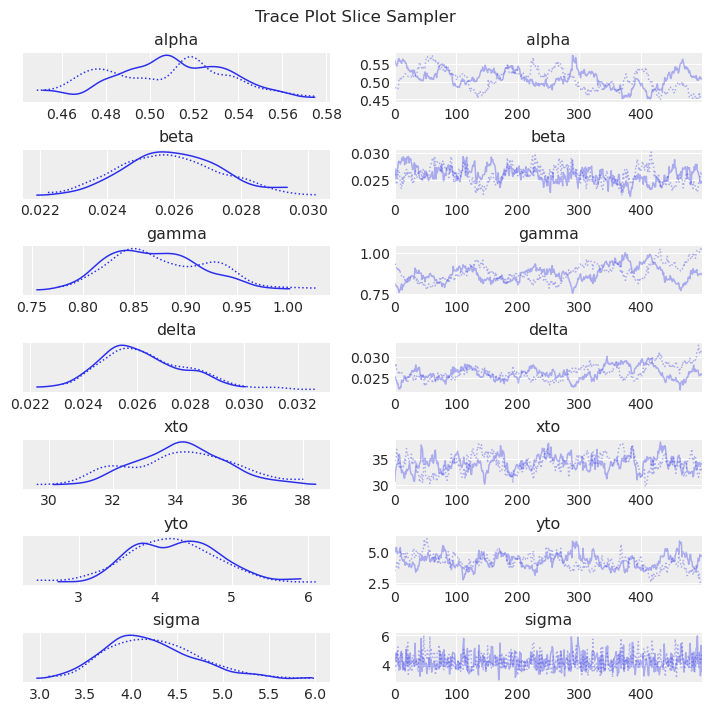

In [69]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

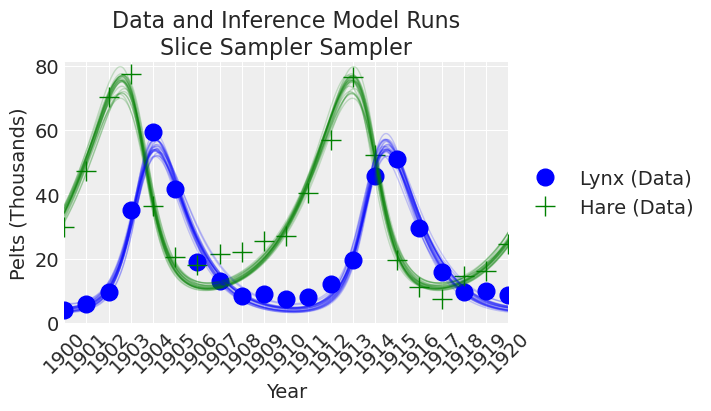

In [70]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
The Slice sampler was slow and resulted in a low effective sample size.  Despite this, the results are starting to look reasonable!  

### DE MetropolisZ Sampler

In [71]:
sampler = "DEMetropolisZ"
tune = draws = 5000
with model:
    trace_DEMZ = pm.sample(step=[pm.DEMetropolisZ(vars_list)], tune=tune, draws=draws, cores=1)
trace = trace_DEMZ
az.summary(trace)

Sequential sampling (2 chains in 1 job)
DEMetropolisZ: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 213 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.486  0.040   0.412    0.558      0.002    0.002     354.0     572.0   
beta    0.025  0.002   0.022    0.029      0.000    0.000     317.0     498.0   
gamma   0.921  0.081   0.774    1.076      0.004    0.003     371.0     616.0   
delta   0.027  0.002   0.023    0.032      0.000    0.000     372.0     643.0   
xto    34.921  1.644  31.715   37.833      0.083    0.059     395.0     545.0   
yto     3.968  0.646   2.781    5.161      0.032    0.023     402.0     784.0   
sigma   4.197  0.529   3.337    5.237      0.029    0.021     357.0     418.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0  
sigma    1.0

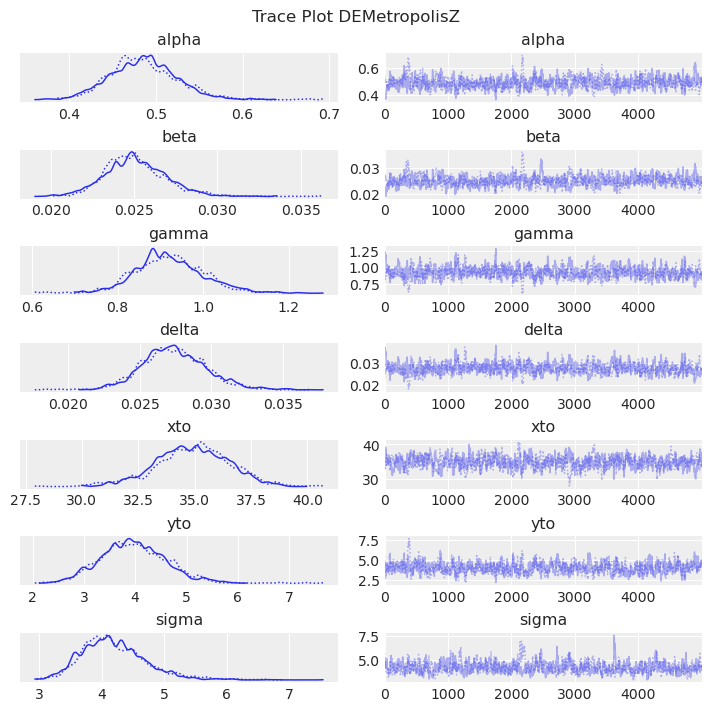

In [72]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

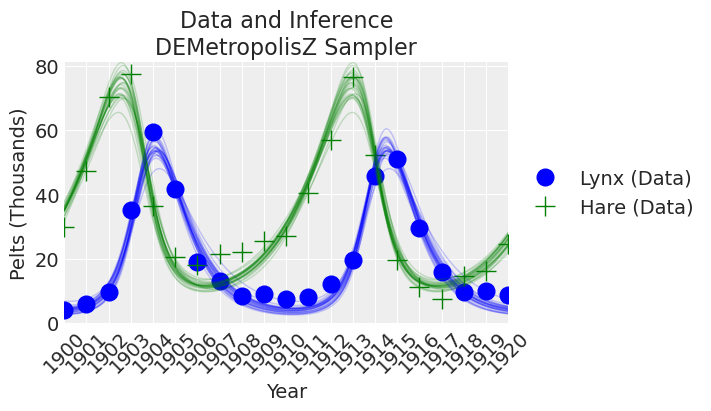

In [73]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_inference(ax, trace, title=f"Data and Inference\n{sampler} Sampler")

**Notes:**  
DEMetropolisZ sampled much quicker than the Slice sampler and therefore had a higher ESS per minute spent sampling.  The parameter estimates are similar.  A "final" inference would still need to beef up the number of samples.  

### DEMetropolis Sampler

In these experiments, DEMetropolis sampler was not accepting `tune` and requiring `chains` to be at least 8.  We will go with 8 chains and truncate the trace following inference to remove the tuning steps (i.e., the "burn-in").   

In [74]:
sampler = "DEMetropolis"
chains = 8
draws = 3000
with model:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)], draws=draws, chains=chains, cores=1)
trace = trace_DEM
az.summary(trace)

Population sampling (8 chains)
DEMetropolis: [alpha, beta, gamma, delta, xto, yto, sigma]
Chains are not parallelized. You can enable this by passing `pm.sample(cores=n)`, where n > 1.


Sampling 8 chains for 0 tune and 4_000 draw iterations (0 + 32_000 draws total) took 223 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.478  0.043   0.391    0.559      0.003    0.002     305.0     198.0   
beta    0.024  0.002   0.018    0.028      0.000    0.000     223.0     169.0   
gamma   0.934  0.088   0.774    1.090      0.005    0.004     443.0     324.0   
delta   0.028  0.002   0.023    0.032      0.000    0.000     689.0     626.0   
xto    35.473  2.493  31.925   42.403      0.210    0.152     247.0     174.0   
yto     4.191  0.995   2.819    5.800      0.083    0.059     174.0     172.0   
sigma   4.260  1.097   3.174    6.349      0.052    0.041     362.0     158.0   

       r_hat  
alpha   1.02  
beta    1.03  
gamma   1.01  
delta   1.01  
xto     1.02  
yto     1.03  
sigma   1.03

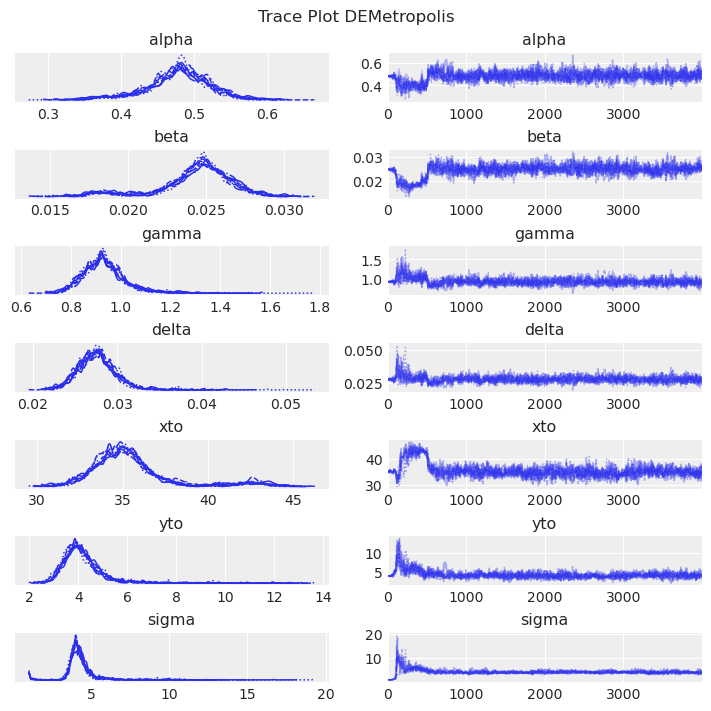

In [75]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

Truncate the trace based on a visual check (~1500 samples).  

In [76]:
# truncate the trace
burn = 1500
trace_DEM = trace_DEM.sel(draw=slice(burn, None), groups="posterior")
trace = trace_DEM
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.486  0.035   0.424    0.554      0.001    0.001     839.0    1524.0   
beta    0.025  0.002   0.022    0.028      0.000    0.000     728.0    1250.0   
gamma   0.921  0.071   0.799    1.064      0.002    0.002     842.0    1583.0   
delta   0.027  0.002   0.024    0.031      0.000    0.000     772.0    1736.0   
xto    34.797  1.460  31.928   37.489      0.056    0.039     687.0    1308.0   
yto     3.944  0.576   2.930    5.080      0.023    0.016     644.0    1477.0   
sigma   4.128  0.390   3.398    4.875      0.017    0.012     531.0    1225.0   

       r_hat  
alpha   1.01  
beta    1.02  
gamma   1.01  
delta   1.01  
xto     1.01  
yto     1.01  
sigma   1.01

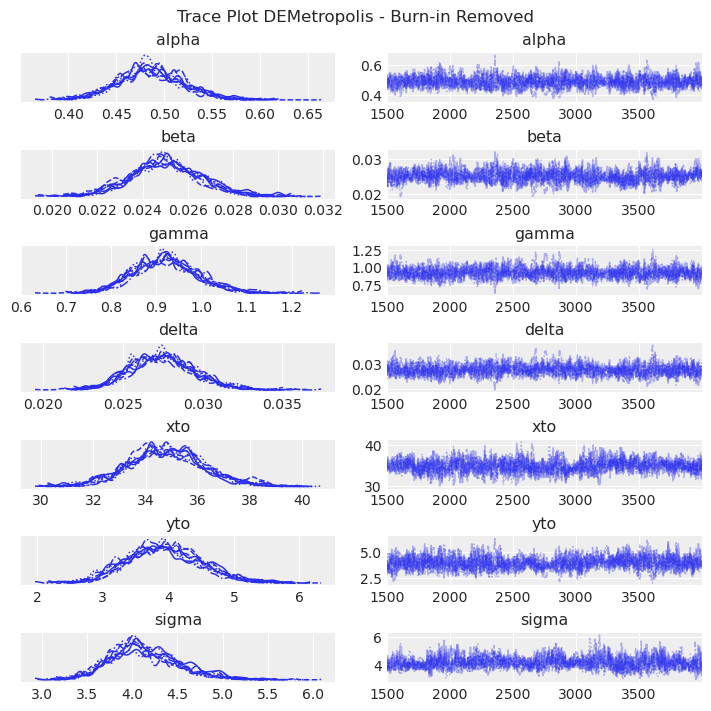

In [77]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler} - Burn-in Removed");

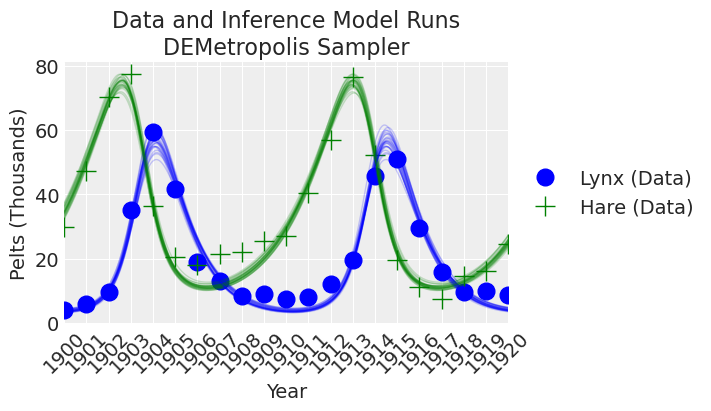

In [78]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
After cleaning up the burn-in portion of the trace, the ESS is high, given the duration of sampling.  

### Metropolis Sampler

In [79]:
sampler = "Metropolis"
tune = draws = 2000
with model:
    trace_M = pm.sample(step=[pm.Metropolis(vars_list)], tune=tune, draws=draws, cores=1)
trace = trace_M
az.summary(trace)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [gamma]
>Metropolis: [delta]
>Metropolis: [xto]
>Metropolis: [yto]
>Metropolis: [sigma]


C:\Users\greg\.conda\envs\pymc-dev\Lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


C:\Users\greg\.conda\envs\pymc-dev\Lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 377 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.496  0.029   0.429    0.550      0.013    0.010       5.0      21.0   
beta    0.025  0.002   0.022    0.028      0.000    0.000      12.0      31.0   
gamma   0.902  0.057   0.805    1.032      0.028    0.021       4.0      22.0   
delta   0.027  0.002   0.024    0.030      0.001    0.001       4.0      20.0   
xto    34.473  1.530  32.087   37.625      0.261    0.186      34.0      52.0   
yto     4.100  0.530   3.254    5.140      0.213    0.159       6.0      27.0   
sigma   4.173  0.504   3.292    5.078      0.034    0.024     236.0     476.0   

       r_hat  
alpha   1.38  
beta    1.13  
gamma   1.44  
delta   1.48  
xto     1.09  
yto     1.25  
sigma   1.02

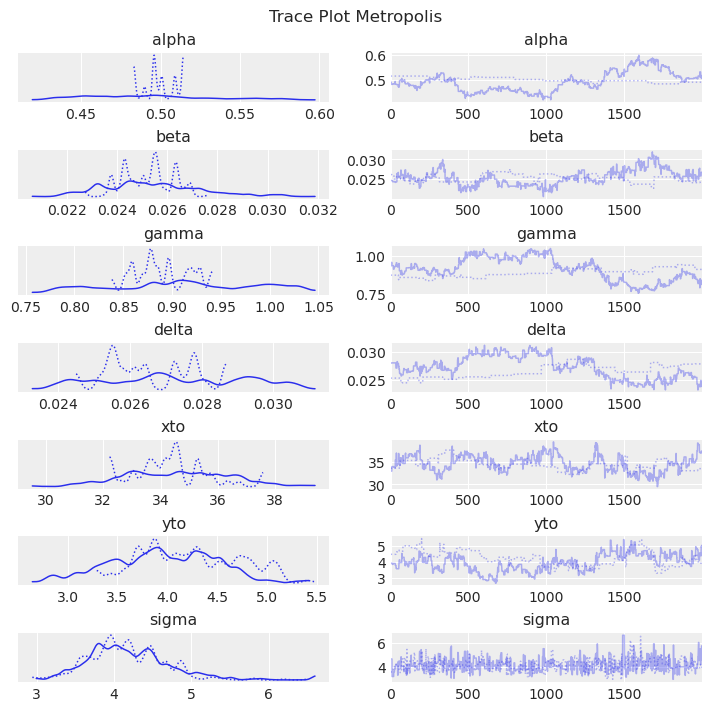

In [80]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

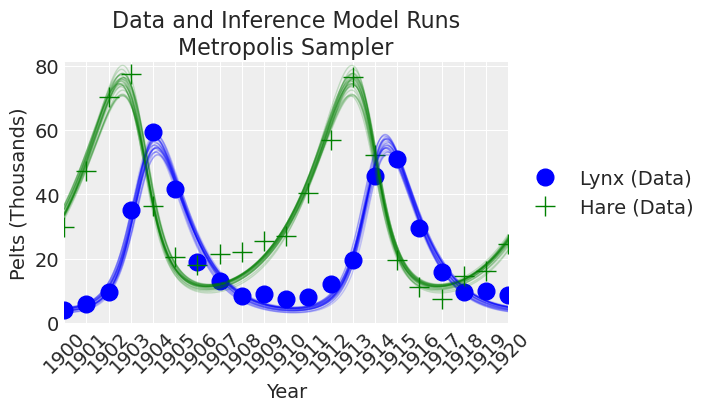

In [81]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
The old-school Metropolis sampler is less reliable and slower than the DEMetroplis samplers.  Not recommended.   

## SMC Sampler

The Sequential Monte Carlo (SMC) sampler is often presented as a likelihood-free method, however, it can also be used with a likelihood function.  First, we will demonstrate its use with a likelihood function based on the model above, and then we will demonstrate its use with a distance function and compare the results.   

### SMC with a Likelihood Function

In [82]:
sampler = "SMC with Likelihood"
draws = 500
with model:
    trace_SMC_like = pm.sample_smc(draws=draws, progressbar=True, cores=1)
trace = trace_SMC_like
az.summary(trace)

Initializing SMC sampler...
Sampling 2 chains in 1 job


C:\Users\greg\.conda\envs\pymc-dev\Lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


C:\Users\greg\.conda\envs\pymc-dev\Lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.514  0.078   0.383    0.663      0.024    0.018      11.0     147.0   
beta    0.027  0.004   0.020    0.034      0.001    0.001      21.0      98.0   
gamma   0.890  0.135   0.615    1.125      0.038    0.028      12.0     228.0   
delta   0.027  0.004   0.019    0.034      0.001    0.001      23.0     147.0   
xto    33.757  3.063  27.615   39.082      0.818    0.591      15.0     246.0   
yto     4.165  1.235   2.207    6.528      0.318    0.229      17.0     159.0   
sigma   6.707  1.350   4.766    8.693      0.896    0.739       3.0      60.0   

       r_hat  
alpha   1.12  
beta    1.07  
gamma   1.11  
delta   1.06  
xto     1.10  
yto     1.08  
sigma   1.83

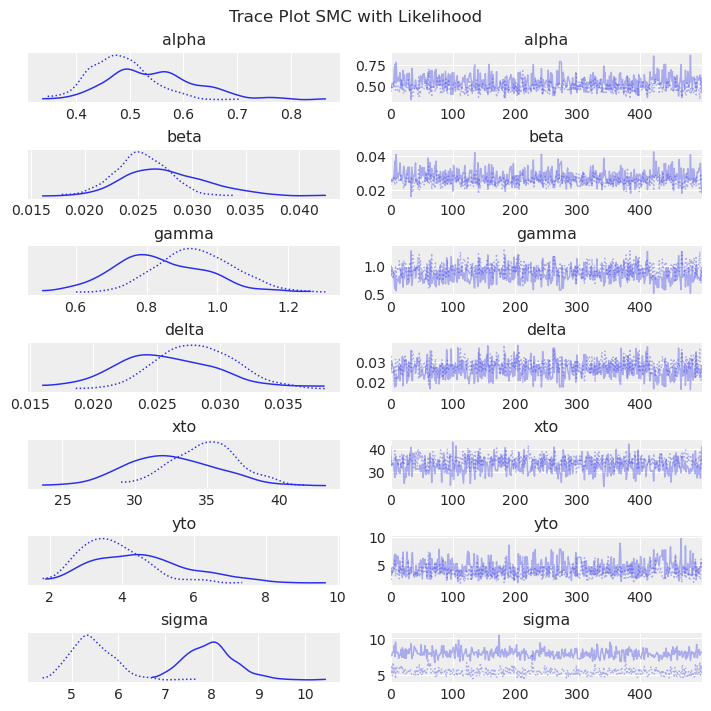

In [83]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

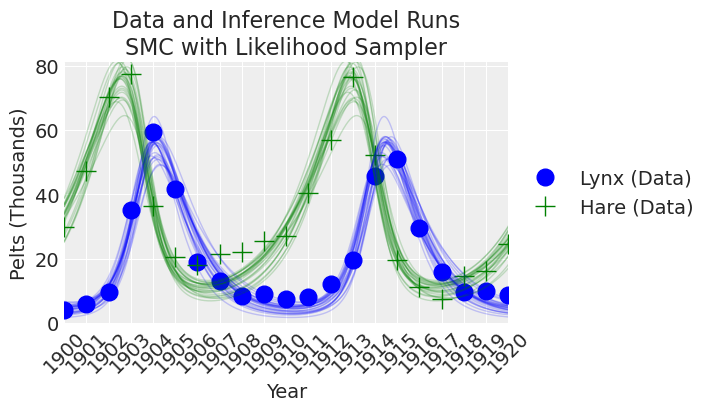

In [84]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
At this number of samples and tuning scheme, the SMC algorithm results in wider uncertainty bounds compared with the other samplers.  

### SMC Using `pm.Simulator` Epsilon=1

As outlined in the SMC tutorial on PyMC.io, the SMC sampler is often combined with a `pm.Simulator` function rather than a Pytensor op.  Here is a rewrite of the PyMC - odeint model for the SMC sampler.

The simulator function needs to have the correct signature (e.g., accept an rng argument first).  

In [85]:
# simulator function based on the signature rng, parameters, size.
def simulator_forward_model(rng, alpha, beta, gamma, delta, xt0, yt0, size=None):
    theta = alpha, beta, gamma, delta, xt0, yt0
    return odeint(func=rhs, y0=theta[-2:], t=data.year, args=(theta,))

Here is the model with the simulator function.  This specification of SMC does not use a likelihood function but rather specifies a distance metric epsilon between the model and observed values.   

In [86]:
with pm.Model() as model:
    # Specify prior distributions for model parameters
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=theta[0], lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=theta[1], lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=theta[2], lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=theta[3], lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=theta[4], lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=theta[5], lower=0, initval=theta[5])

    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(alpha, beta, gamma, delta, xt0, yt0),
        epsilon=1,
        observed=data[["hare", "lynx"]].values,
    )

Inference.  Note the `progressbar` was throwing an error so it is turned off.  

In [87]:
sampler = "SMC_epsilon=1"
draws = 300
with model:
    trace_SMC_e1 = pm.sample_smc(draws=draws, progressbar=False)
trace = trace_SMC_e1
az.summary(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.482  0.009   0.463    0.498      0.000    0.000    1284.0    1170.0   
beta    0.025  0.000   0.024    0.026      0.000    0.000    1171.0    1174.0   
gamma   0.925  0.019   0.891    0.962      0.001    0.000    1286.0    1132.0   
delta   0.028  0.001   0.026    0.028      0.000    0.000    1115.0    1132.0   
xto    34.910  0.403  34.154   35.633      0.011    0.008    1251.0    1274.0   
yto     3.871  0.151   3.593    4.146      0.004    0.003    1272.0    1028.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0

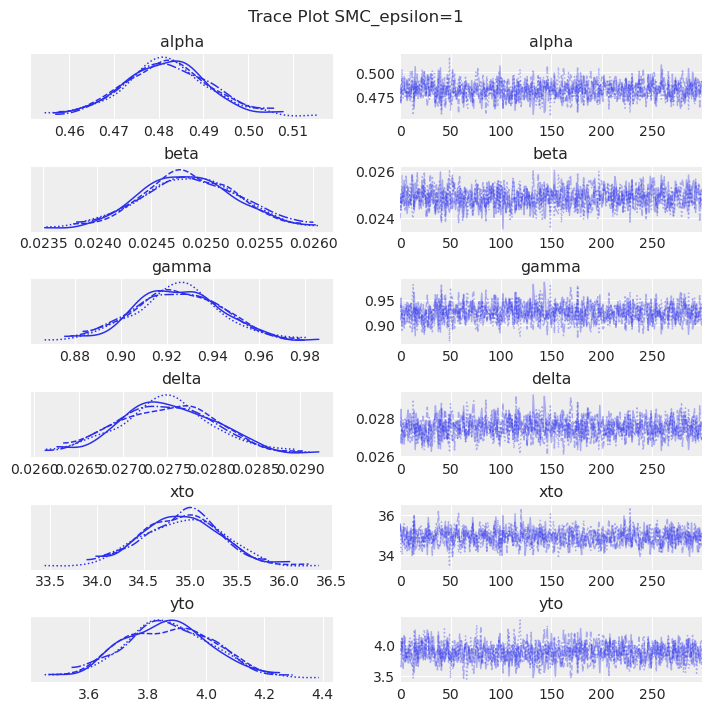

In [88]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

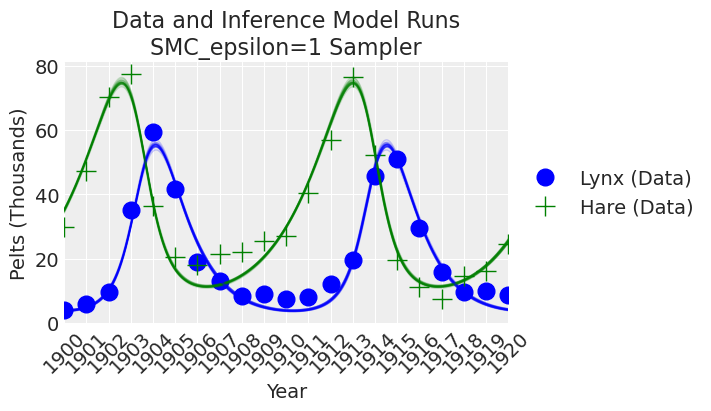

In [89]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
This is interesting.  The SMC sampler underestimates uncertainty compared to the other samplers.  What is going on?  Remember that the SMC sampler is using distance rather than a likelihood function.  So when epsilon is small, the parameter estimates are essentially converging toward the least squares estimate.  Let's try again with a larger epsilon.

### SMC with Epsilon = 10

In [90]:
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=theta[0], lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=theta[1], lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=theta[2], lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=theta[3], lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=theta[4], lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=theta[5], lower=0, initval=theta[5])

    # ode_solution
    pm.Simulator(
        "Y_obs",
        simulator_forward_model,
        params=(alpha, beta, gamma, delta, xt0, yt0),
        epsilon=10,
        observed=data[["hare", "lynx"]].values,
    )

In [91]:
sampler = "SMC epsilon=10"
draws = 300
with model:
    trace_SMC_e10 = pm.sample_smc(draws=draws, progressbar=False)
trace = trace_SMC_e10
az.summary(trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.497  0.085   0.341    0.650      0.002    0.002    1195.0    1168.0   
beta    0.026  0.004   0.018    0.034      0.000    0.000    1202.0    1079.0   
gamma   0.926  0.165   0.636    1.244      0.005    0.003    1180.0    1165.0   
delta   0.028  0.005   0.019    0.037      0.000    0.000    1162.0    1158.0   
xto    34.509  3.870  26.826   41.378      0.113    0.080    1180.0    1073.0   
yto     4.138  1.381   1.816    6.779      0.040    0.028    1181.0    1171.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
xto      1.0  
yto      1.0

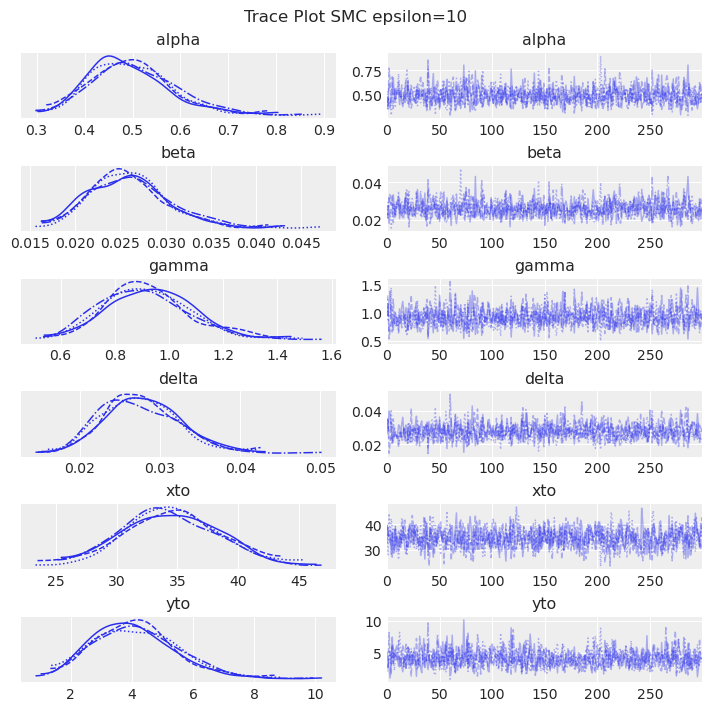

In [92]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

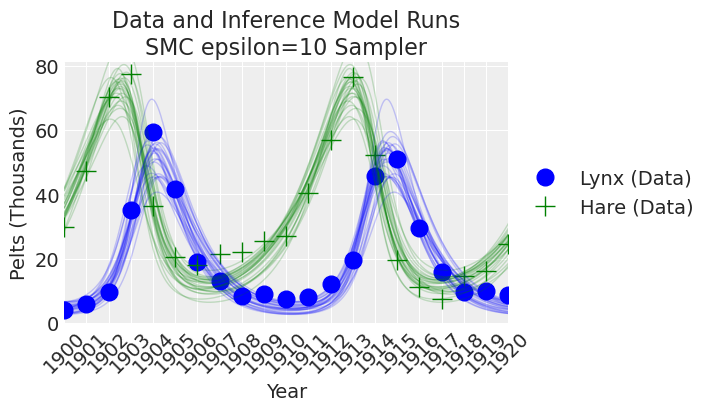

In [93]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
Now, we see that the SMC sampler with a larger epsilon over-estimates parameter uncertainty compared to the other samplers.  So which value for epsilon in "right"?  In a sense, the likelihood function used in other model specification finds the right value for the model error (sigma), to balance the uncertainty in model parameters and noise in the data.  This specification of SMC does not have that feature, since epsilon is specified by the user rather than discovered by the model.     

## Posterior Correlations
At this point, it is worth pointing out that the posterior parameter space is a difficult geometry for sampling.  

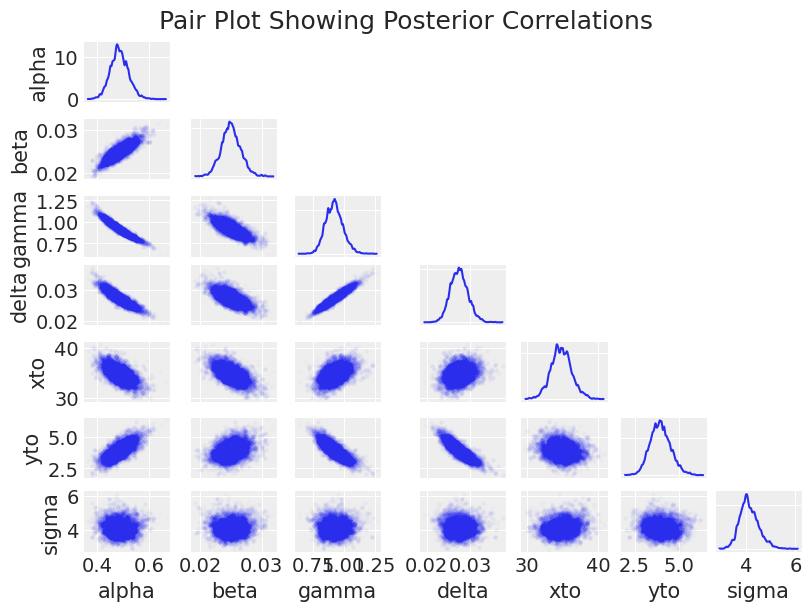

In [94]:
az.plot_pair(trace_DEM, figsize=(8, 6), scatter_kwargs=dict(alpha=0.01), marginals=True)
plt.suptitle("Pair Plot Showing Posterior Correlations", size=18);

The major observation here is that the posterior shape is pretty difficult for a sampler to handle, with positive correlations, negative correlations, crecent-shapes, and large variations in scale.  This contributes to the slow sampling (in addition to the computational overhead in solving the ODE thousands of times).  This is also fun to look at for understanding how the model equations fit together.       

## Bayesian Inference with Gradients

The PyMC default NUTs sampler can only be used if gradients are supplied to the sampler.  In this section, we will solve the system of ODEs within PyMC in two different ways that supply the sampler with gradients.  The first is the built-in `pymc.ode.DifferentialEquation` solver, and the second is to forward simulate using `pytensor.scan`, which allows looping.  Note that there may be other better and faster ways to perform Bayesian inference with ODEs using gradients, such as the [sunode](https://sunode.readthedocs.io/en/latest/index.html) project, and [diffrax](https://www.pymc-labs.io/blog-posts/jax-functions-in-pymc-3-quick-examples/), which relies on JAX.

### PyMC ODE Module

`Pymc.ode` uses `scipy.odeint` under the hood to estimate a solution and then estimate the gradient through finite differences. 

The `pymc.ode` API is similar to `scipy.odeint`.  The right-hand-side equations are put in a function and written as if `y` and `p` are vectors, as follows.  (Even when your model has one state and/or one parameter, you should explicitly write `y[0]` and/or `p[0]`.)

In [95]:
def rhs_pymcode(y, t, p):
    dX_dt = p[0] * y[0] - p[1] * y[0] * y[1]
    dY_dt = -p[2] * y[1] + p[3] * y[0] * y[1]
    return [dX_dt, dY_dt]

`DifferentialEquation` takes as arguments:

* `func`: A function specifying the differential equation (i.e. $f(\mathbf{y},t,\mathbf{p})$),
* `times`: An array of times at which data was observed,
* `n_states`: The dimension of $f(\mathbf{y},t,\mathbf{p})$ (number of output parameters),
* `n_theta`: The dimension of $\mathbf{p}$ (number of input parameters),
* `t0`: Optional time to which the initial condition belongs,  

as follows:

In [96]:
ode_model = DifferentialEquation(
    func=rhs_pymcode, times=data.year.values, n_states=2, n_theta=4, t0=data.year.values[0]
)

Once the ODE is specified, we can use it in our PyMC model.

#### NUTs Inference
`pymc.ode` is quite slow, so for demonstration purposes, we will only draw a few samples.  

In [97]:
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=theta[0], lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=theta[1], lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=theta[2], lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=theta[3], lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=theta[4], lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=theta[5], lower=0, initval=theta[5])
    sigma = pm.TruncatedNormal("sigma", mu=10, sigma=10, lower=0)

    # ode_solution
    ode_solution = ode_model(y0=[xt0, yt0], theta=[alpha, beta, gamma, delta])

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

In [98]:
sampler = "NUTs PyMC ODE"
tune = draws = 25
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws)

Only 25 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 4 chains for 25 tune and 25 draw iterations (100 + 100 draws total) took 2516 seconds.
C:\Users\greg\AppData\Local\Temp\ipykernel_10828\2204089278.py:4: UserWarning: The number of samples is too small to check convergence reliably.
  trace_pymc_ode = pm.sample(tune=tune, draws=draws)


In [99]:
trace = trace_pymc_ode
az.summary(trace)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   0.355   0.241   0.040    0.820      0.089    0.065       8.0   
beta    0.025   0.009   0.010    0.047      0.003    0.002      10.0   
gamma   1.046   0.734   0.162    2.687      0.279    0.207       7.0   
delta   0.037   0.019   0.013    0.081      0.007    0.005       9.0   
xto    32.837  12.536  18.054   64.653      4.390    3.222       8.0   
yto     6.698   2.631   3.032   11.270      0.897    0.657       8.0   
sigma  15.521  11.043   1.958   27.991      2.555    1.836      12.0   

       ess_tail  r_hat  
alpha      52.0   2.09  
beta       29.0   1.49  
gamma      17.0   2.67  
delta      18.0   1.76  
xto        18.0   1.89  
yto        14.0   1.95  
sigma      14.0   1.94

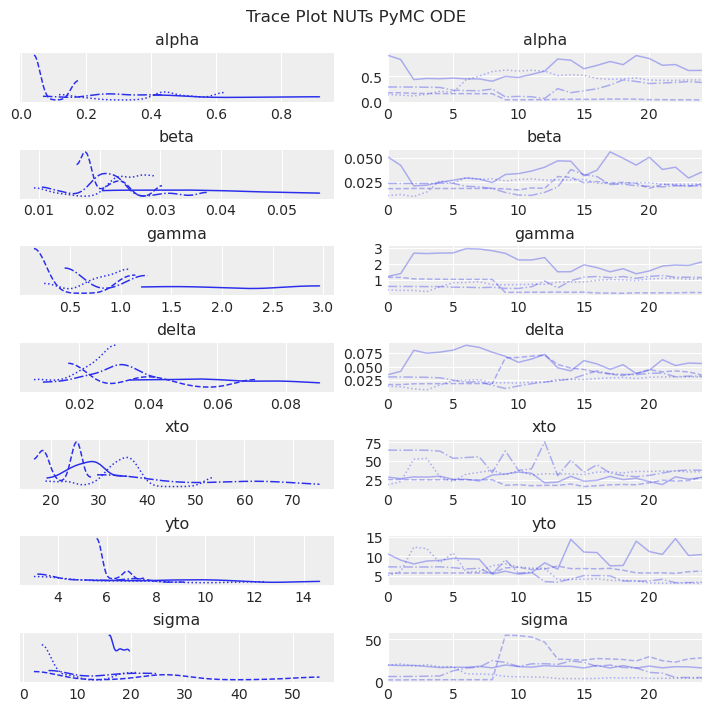

In [100]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

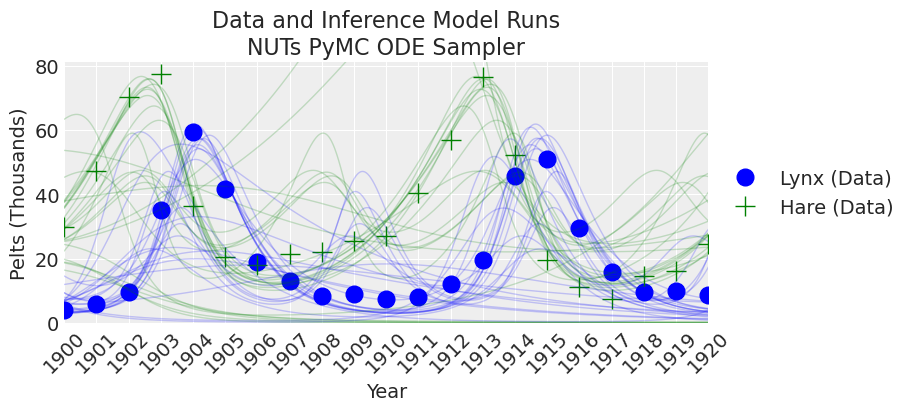

In [101]:
fig, ax = plt.subplots(figsize=(9, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
Despite a paucity of samples, the NUTs sampler is starting to converge to the correct posterior.   

### Simulate with Pytensor Scan

Finally, we can write the system of ODEs as a forward simulation solver within PyMC.  The way to write for-loops in PyMC is with `pytensor.scan.`  Gradients are then supplied to the sampler via autodifferentiation.    

First, we should test that the time steps are sufficiently small to get a reasonable estimate.  

#### Check Time Steps

Create a function that accepts different numbers of time steps for testing.  The function also demonstrates how `pytensor.scan` is used.  

In [102]:
# Lotka-Volterra forward simulation model using scan
def lv_scan_simulation_model(theta, steps_year=100, years=21):

    # variables to control time steps
    n_steps = years * steps_year
    dt = 1 / steps_year

    # PyMC model
    with pm.Model() as model:
        # Priors (these are static for testing)
        alpha = theta[0]
        beta = theta[1]
        gamma = theta[2]
        delta = theta[3]
        xt0 = theta[4]
        yt0 = theta[5]

        # Lotka-Volterra calculation function
        ## Similar to the right-hand-side functions used earlier
        ## but with dt applied to the equations
        def ode_update_function(x, y, alpha, beta, gamma, delta):
            x_new = x + (alpha * x - beta * x * y) * dt
            y_new = y + (-gamma * y + delta * x * y) * dt
            return x_new, y_new

        # Pytensor scan looping function
        ## The function argument names are not intuitive in this context!
        result, updates = pytensor.scan(
            fn=ode_update_function,  # function
            outputs_info=[xt0, yt0],  # initial conditions
            non_sequences=[alpha, beta, gamma, delta],  # parameters
            n_steps=n_steps,
        )  # number of loops

        # Put the results together and track the result
        pm.Deterministic("result", pm.math.stack([result[0], result[1]], axis=1))

    return model

Run the simulation for various time steps and plot the results.   

Sampling: []
Sampling: []
Sampling: []
Sampling: []


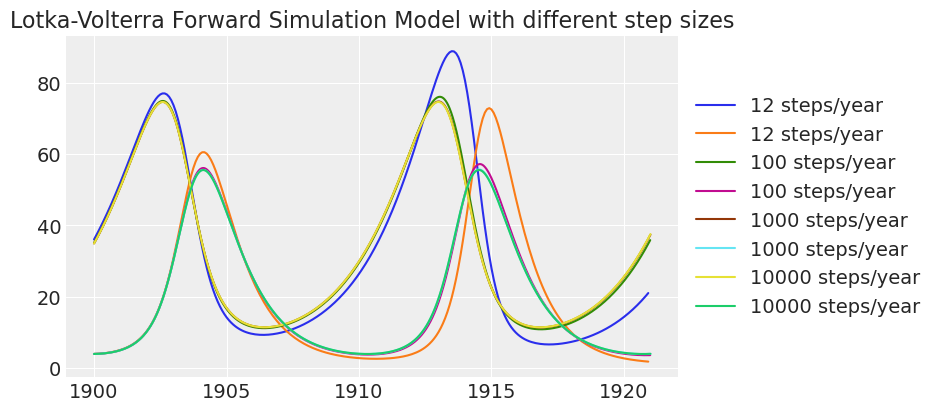

In [103]:
fig, ax = plt.subplots(figsize=(9, 4))

steps_years = [12, 100, 1000, 10000]
for steps_year in steps_years:
    time = np.arange(1900, 1921, 1 / steps_year)
    model = lv_scan_simulation_model(theta, steps_year=steps_year)
    with model:
        prior = pm.sample_prior_predictive(1)
    ax.plot(time, prior.prior.result[0][0].values, label=str(steps_year) + " steps/year")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Lotka-Volterra Forward Simulation Model with different step sizes");

Notice how the lower resolution simulations are less accurate over time.  Based on this check, 100 time steps per year is sufficiently accurate.  12 steps per year has too much "numerical diffusion" over 20 years of simulation.    

#### Inference Using NUTs

Now that we are OK with 100 time steps per year, we write the model with indexing to align the data with the results.  

In [104]:
def lv_scan_inference_model(theta, steps_year=100, years=21):

    # variables to control time steps
    n_steps = years * steps_year
    dt = 1 / steps_year

    # variables to control indexing to get annual values
    segment = [True] + [False] * (steps_year - 1)
    boolist_idxs = []
    for _ in range(years):
        boolist_idxs += segment

    # PyMC model
    with pm.Model() as model:
        # Priors
        alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=theta[0], lower=0, initval=theta[0])
        beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=theta[1], lower=0, initval=theta[1])
        gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=theta[2], lower=0, initval=theta[2])
        delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=theta[3], lower=0, initval=theta[3])
        xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=theta[4], lower=0, initval=theta[4])
        yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=theta[5], lower=0, initval=theta[5])
        sigma = pm.TruncatedNormal("sigma", mu=10, sigma=10, lower=0)

        # Lotka-Volterra calculation function
        def ode_update_function(x, y, alpha, beta, gamma, delta):
            x_new = x + (alpha * x - beta * x * y) * dt
            y_new = y + (-gamma * y + delta * x * y) * dt
            return x_new, y_new

        # Pytensor scan is a looping function
        result, updates = pytensor.scan(
            fn=ode_update_function,  # function
            outputs_info=[xt0, yt0],  # initial conditions
            non_sequences=[alpha, beta, gamma, delta],  # parameters
            n_steps=n_steps,
        )  # number of loops

        # Put the results together
        final_result = pm.math.stack([result[0], result[1]], axis=1)
        # Filter the results down to annual values
        annual_value = final_result[np.array(boolist_idxs), :]

        # Likelihood function
        pm.Normal("Y_obs", mu=annual_value, sigma=sigma, observed=data[["hare", "lynx"]].values)
    return model

This is also quite slow, so we will just pull a few samples for demonstration purposes.  

In [105]:
steps_year = 100
model = lv_scan_inference_model(theta, steps_year=steps_year)
sampler = "NUTs Pytensor Scan"
tune = draws = 50
with model:
    trace_scan = pm.sample(tune=tune, draws=draws)

Only 50 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, xto, yto, sigma]


Sampling 4 chains for 50 tune and 50 draw iterations (200 + 200 draws total) took 419 seconds.
C:\Users\greg\AppData\Local\Temp\ipykernel_10828\1292993890.py:6: UserWarning: The number of samples is too small to check convergence reliably.
  trace_scan = pm.sample(tune=tune, draws=draws)


In [106]:
trace = trace_scan
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha   0.498  0.046   0.416    0.586      0.005    0.003     100.0      55.0   
beta    0.026  0.002   0.022    0.030      0.000    0.000     133.0      90.0   
gamma   0.901  0.087   0.746    1.077      0.009    0.006      92.0      62.0   
delta   0.027  0.002   0.022    0.031      0.000    0.000      87.0      71.0   
xto    34.599  1.826  31.234   37.637      0.159    0.112     137.0      72.0   
yto     4.267  0.708   3.148    5.693      0.074    0.053      94.0     115.0   
sigma   4.377  0.568   3.305    5.419      0.052    0.037     120.0     105.0   

       r_hat  
alpha   1.05  
beta    1.03  
gamma   1.04  
delta   1.04  
xto     1.03  
yto     1.03  
sigma   1.05

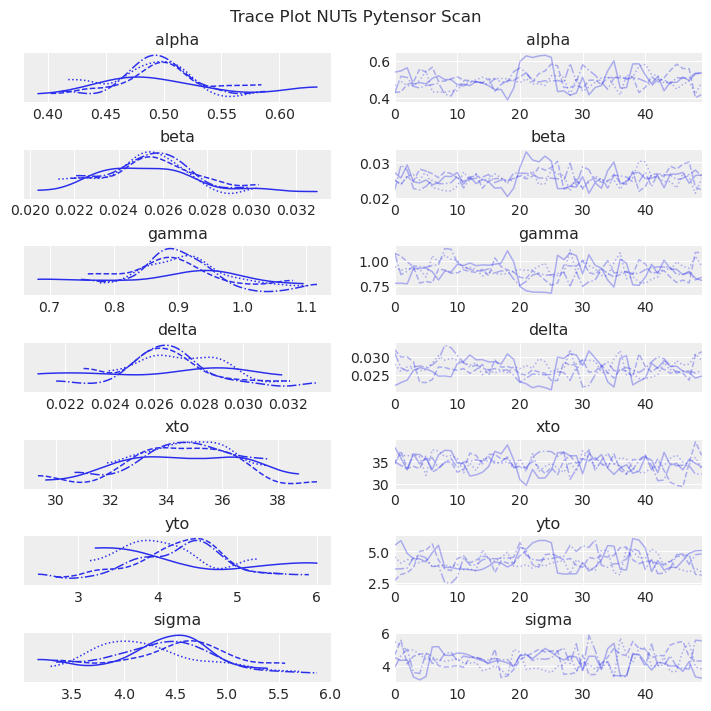

In [107]:
az.plot_trace(trace, figsize=(7, 7))
plt.suptitle(f"Trace Plot {sampler}");

In [108]:
time = np.arange(1900, 1921, 0.01)
odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,)).shape

(2100, 2)

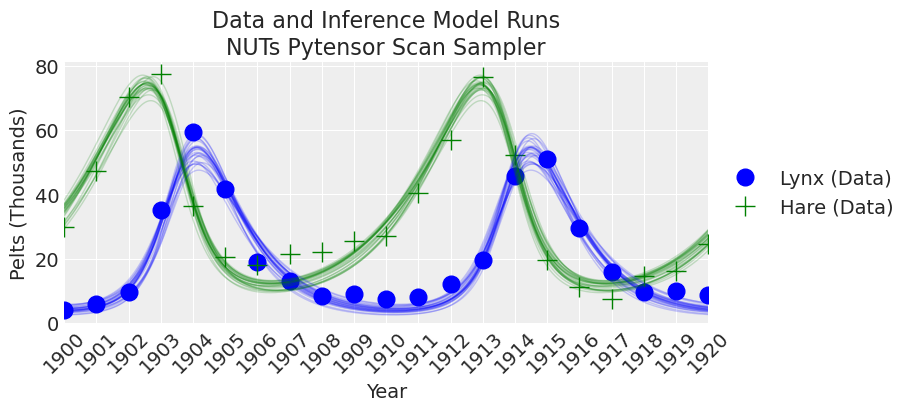

In [109]:
fig, ax = plt.subplots(figsize=(9, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");

**Notes:**  
The sampler is faster than the `pymc.ode` implementation, but still slower than scipy `odeint` combined with gradient-free inference methods. 

## Summary

Let's compare inference results among these different methods.  Recall that, in order to run this notebook in a reasonable amount of time, we have an insufficient number of samples for many inference methods.  For a fair comparison, we would need to bump up the number of samples and run the notebook for longer.  Regardless, let's take a look.     

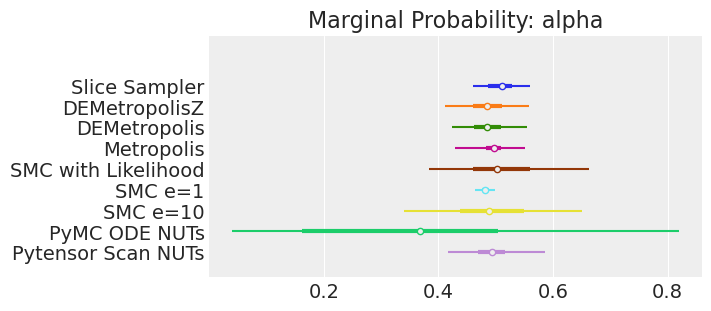

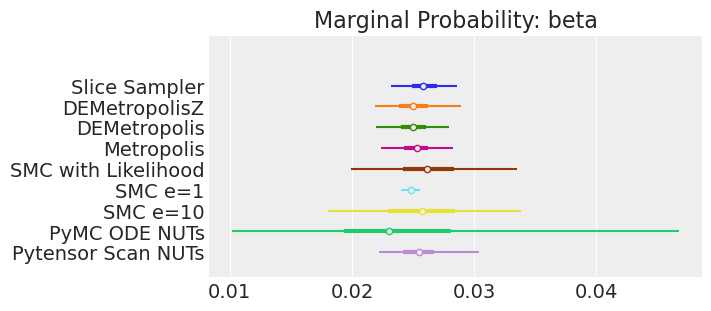

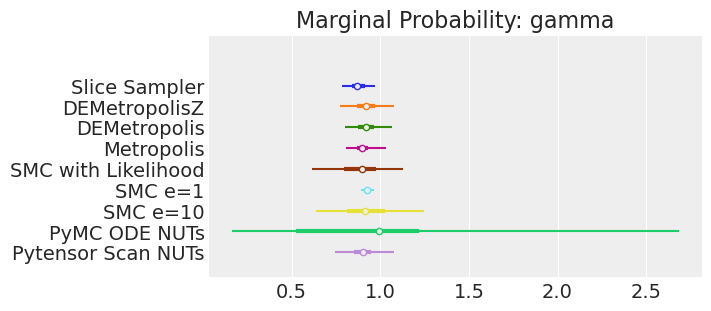

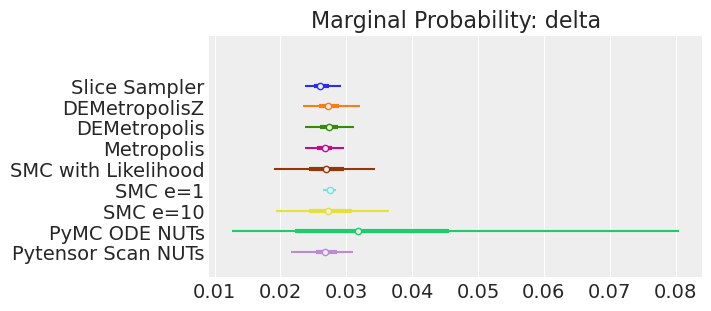

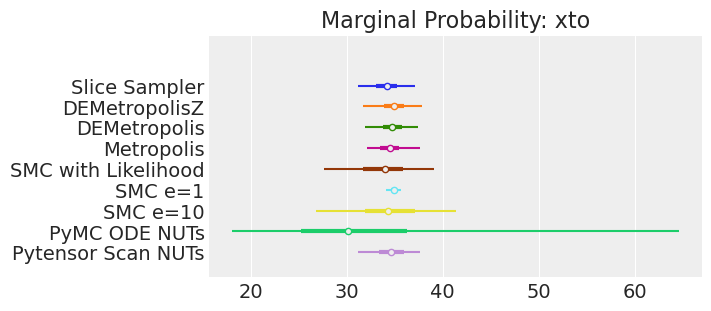

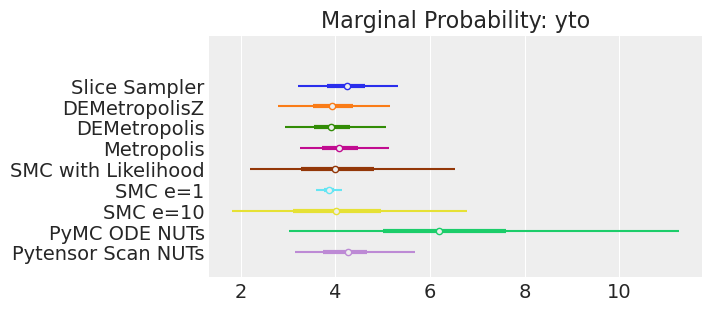

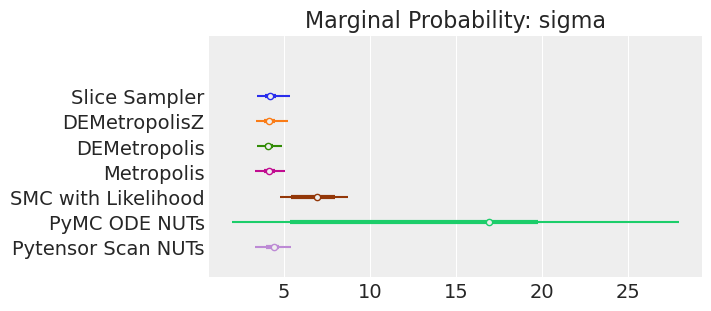

In [110]:
# Make lists with variable for looping
var_names = [str(s).split("_")[0] for s in list(model.values_to_rvs.keys())[:-1]]
# Make lists with model results and model names for plotting
inference_results = [
    trace_slice,
    trace_DEMZ,
    trace_DEM,
    trace_M,
    trace_SMC_like,
    trace_SMC_e1,
    trace_SMC_e10,
    trace_pymc_ode,
    trace_scan,
]
model_names = [
    "Slice Sampler",
    "DEMetropolisZ",
    "DEMetropolis",
    "Metropolis",
    "SMC with Likelihood",
    "SMC e=1",
    "SMC e=10",
    "PyMC ODE NUTs",
    "Pytensor Scan NUTs",
]

# Loop through variable names
for var_name in var_names:
    axes = az.plot_forest(
        inference_results,
        model_names=model_names,
        var_names=var_name,
        kind="forestplot",
        legend=False,
        combined=True,
        figsize=(7, 3),
    )
    axes[0].set_title(f"Marginal Probability: {var_name}")
    # Clean up ytick labels
    ylabels = axes[0].get_yticklabels()
    new_ylabels = []
    for label in ylabels:
        txt = label.get_text()
        txt = txt.replace(": " + var_name, "")
        label.set_text(txt)
        new_ylabels.append(label)
    axes[0].set_yticklabels(new_ylabels)

    plt.show();

**Notes:**  
If we ran the samplers for long enough to get good inferences, we would expect them to converge on the same posterior probability distributions, with the exception of SMC when using a distance parameter (SMC e=1 and SMC e=10).  When using a distance parameter, the model does not include a likelihood function and therefore represents a different posterior probability distribution than the other models.

### Key Conclusions
We performed Bayesian inference on a system of ODEs in 4 main ways: 
* Scipy `odeint` wrapped in a Pytensor `op` and sampled with non-gradient-based samplers (comparing 5 different samplers).  
* Scipy `odeint` wrapped in a `pm.Simulator` function and sampled with a non-likelihood-based sequential Monte Carlo (SMC) sampler.  
* PyMC `ode.DifferentialEquation` sampled with NUTs.  
* Forward simulation using `pytensor.scan` and sampled with NUTs.  

The "winner" for this problem was the Scipy `odeint` solver with a differential evolution (DE) Metropolis sampler.  The improved efficiency of the NUTs sampler did not make up for the inefficiency in using the slow ODE solvers with gradients.  Sticking with Scipy and DEMetropolis is also the simplest workflow for a scientist with a working numeric model and the desire to perform Bayesian inference.  Just wrapping the numeric model in a Pytensor op and plugging it into a PyMC model can get you a long way!  

## Authors
Organized and rewritten by Greg Brunkhorst from multiple PyMC.io example notebooks by Sanmitra Ghosh, Demetri Pananos, and the PyMC Team.

In [111]:
%watermark -n -u -v -iv -w

Last updated: Tue Jan 10 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.7.0

arviz     : 0.14.0
pymc      : 5.0.1+5.ga7f361bd
pandas    : 1.5.2
pytensor  : 2.9.1
matplotlib: 3.6.2
numpy     : 1.24.0

Watermark: 2.3.1



:::{include} ../page_footer.md
:::